**Name:** \_\_\_\_\_Huanchen Wang\_\_\_\_\_

**EID:** \_\_\_\_\_huancwang2\_\_\_\_\_

**Kaggle Team Name:** \_\_\_\_\_Unknown Wang\_\_\_\_\_

# CS5489 - Assignment 2 - Game Music Tagging
Due date: see Assignment 2 on Canvas

## Goal
In this assignment, the task is to annotate or tag a music clip with descriptive (semantic) keywords.  This kind of content-based tagging system could be useful to musicians and sound engineers who want to automatically organize their sound library, or search for sound or music by keyword.

## Dataset of 80s Game Music

This dataset contains video game music from an 80s-era programmable sound generator based on FM (frequency modulation). The music was for Sega and MSX PC games. Each song is annotated with emotion tags. _The data is publicly available - please do not search for it and cheat._


## Methodology
Semantic annotation is a multi-label classification problem, where each label corresponds to one sound tag and is a binary classification problem. The labels can co-occur (multiple labels can be assigned to the same sound), which makes it different from multi-class classification (where only one label can be assigned).  Sound is a temporal process, so the important thing is how to define the _feature space_ for representing the sound, before learning the binary classifiers. You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space for sound annotation.  You are free to use methods that were not introduced in class, as long as you present the details in the report.  You can also consider the co-occurence of the labels to help with the multi-label classification.


## Evaluation of Tagging

For evaluation, you will predict the presence/absence of tags for each test sound. The evaluation metric is "Mean column-wise AUC".  AUC is the area under the ROC curve, which plots FPR vs TPR.  "Mean column-wise" computes the average of the AUCs for the tags.  To compute AUC, you will need to predict the score of each label (e.g., decision function value, probability, etc.) rather than the label.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas. You must submit your Kaggle account name to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline. This is to prevent students from creating multiple Kaggle accounts to gain unfair advantage.

**Note:** You can only submit 2 times per day to Kaggle!


## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment2.ipynb` with your source code and documentation.  _**You should write about all the various attempts that you make to find a good solution.**_ You may also submit python scripts as source code, but your documentation must be in the ipynb file.
2. Your final csv submission file to Kaggle.
3. The ipynb file `Assignment2-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**
4. Your Kaggle username (submitted to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline)

Files should be uploaded to Assignment 2 on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 45% - Results using various feature representations, dimensionality reduction methods, classification methods, etc.
- 30% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 5% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

**Note: This is an individual assignment. Every student must turn in their own work!**
<hr>

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def showAudio(info):
    myfile = 'musicmp3/' + info['fname'] + '.mp3'
    if os.path.exists(myfile):
        display(Audio(myfile))
    else:
        print("*** mp3 file " + myfile + " could not be found ***")

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files. Here we assume the data is stored in the `musicdata` directory. The below code will load the data, including tags and extracted features.

In [25]:
train_tags  = load_pickle('musicdata/train_tags.pickle3')
train_mfccs = load_pickle('musicdata/train_mfccs.pickle3')
train_mels  = load_pickle('musicdata/train_mels.pickle3')
train_info  = load_pickle('musicdata/train_info.pickle3')

test_mfccs = load_pickle('musicdata/test_mfccs.pickle3')
test_mels  = load_pickle('musicdata/test_mels.pickle3')
test_info  = load_pickle('musicdata/test_info.pickle3')

In [17]:
len(test_info)

168

Here are the things in the dataset:

- `train_info` - info about each sound in the training set.
- `train_mels` - the Mel-frequency spectrogram for each sound in the training set. Mel-frequency is a logarithmically-transformed frequency with better perceptual distance.  More details [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8).
- `train_mfccs` -  MFCCs (Mel-frequency cepstrum coefficients) are dimensionality-reduced version of the Mel-frequency spectrogram. Specifically, the log is applied to the magnitudes, and then a Discrete Cosine Transform is applied at each time. 
- `train_tags` - the descriptive tags for each sound in the training set.
- `test_info` - info about each sound in the test set.
- `test_mels` - the Mel Spectrogram for each sound in the test.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the one song in the training set, as well as the tags and other info. To play the audio, we assume the mp3s are available in the `musicmp3` directory.

In [5]:
ii = 14
showAudio(train_info[ii])
print(train_tags[ii])
print(train_info[ii])

['fluttered', 'calm']
{'id': 'eb7jboiu', 'tags': ['fluttered', 'calm'], 'top_tag': 'fluttered', 'fname': 'eb7jboiu'}


Here is the Mel-frequency spectrogram, which shows the frequency content over time. The spectrogram is stored in an `B x T` matrix, where `B` is the number of bins, and `T` is the temporal length.  The left plot shows the original Mel spectrogram (with time increasing to the right).  The right plot shows the log magnitude, which can better visualize the differences.  Here we use `B=128` Mel-bins.

(143, 128)


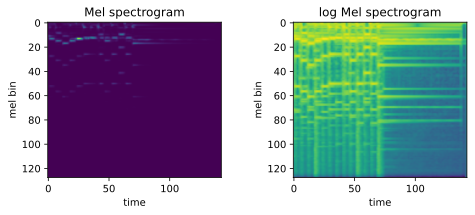

In [6]:
print(train_mels[ii].shape)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.imshow(train_mels[ii].T);
plt.xlabel('time')
plt.ylabel('mel bin');
plt.title('Mel spectrogram')
plt.subplot(1,2,2)
plt.imshow(log(train_mels[ii].T));
plt.xlabel('time')
plt.ylabel('mel bin');
plt.title('log Mel spectrogram')
plt.tight_layout()

MFCCs are a dimensionality-reduced version of the Mel-spectrogram.  To get the MFCC, the Discrete Cosine Transform (DCT) is applied to each 128-dim log-Mel bin vector.  Here we use 20-dimension DCT, so the 128-dim vector is convereted to 20-dim in each time step.  The left plot shows the MFCCs as an image, while the right plots the individual dimensions over time.

(143, 20)


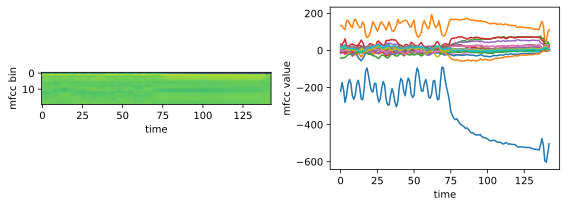

In [7]:
print(train_mfccs[ii].shape)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(train_mfccs[ii].T)
plt.xlabel('time')
plt.ylabel('mfcc bin')
plt.subplot(1,2,2)
plt.plot(train_mfccs[ii]);
plt.xlabel('time')
plt.ylabel('mfcc value');
plt.tight_layout()

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [5]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [6]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [6]:
print(train_dmfccs[0][0])

[-184.3729      88.103615   -13.998435    29.957767   -14.865648
    4.795857    -4.8739123   18.453674     2.810142    11.200221
  -14.67706      3.9444768   -7.754983     3.0393426   -8.849848
   11.00738      2.698762     8.2848625   -4.388589     3.5377586
   97.0066       5.5644913    7.4739122    1.4915733    1.4182262
    3.055902     3.9508502    0.6885147   -6.1345553   -5.370047
   -0.3312292    3.769481     2.8691254    2.739856     0.721117
    1.0148563   -1.7685852   -2.1253805   -4.6949587    2.6014802]


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [7]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(1742938, 40)


In [8]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-2.2776012e+02,  1.6792923e+02,  5.3576927e+00, ...,
         3.6026591e-01,  3.3634314e-01, -2.2023678e-01],
       [-1.7031970e+02,  9.9945198e+01,  1.4115372e+01, ...,
         7.4327271e-03,  2.4297351e-01,  1.0558965e+00],
       [-4.3284125e+02,  5.7973557e+00, -9.6525822e+00, ...,
        -1.0773124e-02,  6.8042761e-01,  8.2857154e-02],
       ...,
       [-1.5053831e+02,  6.3272598e+01,  1.5092019e+01, ...,
         5.0454849e-01,  1.1879567e+00,  8.6447018e-01],
       [-1.5146945e+02,  5.7821571e+01,  7.6386547e+00, ...,
        -1.5683421e-01,  7.0671606e-01, -9.3387678e-02],
       [-1.7020773e+02,  9.1661728e+01,  3.6319504e+01, ...,
        -8.6277032e-01, -4.0861821e-01, -6.4709403e-02]], dtype=float32)

Now transform the data into BOW.

In [9]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [10]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

# Tag pre-processing

Next, we extract all the tags from the data, and get a unique list of tags.

In [26]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

bizarre: 48
boring: 10
calm: 63
cheerful: 223
cold: 54
comic: 26
creepy: 74
cute: 38
depressed: 57
dreamy: 59
fluttered: 115
frustrating: 13
grand: 62
peaceful: 75
rhythmic: 150
serious: 166
speedy: 180
tense: 249
touching: 41


Now we convert the list of tags for each sound into binary attributes.

In [6]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [7]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)

In [15]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)

array([ 48.,  10.,  63., 223.,  54.,  26.,  74.,  38.,  57.,  59., 115.,
        13.,  62.,  75., 150., 166., 180., 249.,  41.])

## Baseline experiments

Next, we will run a baseline experiment doing semantic tagging with bag-of-audio words.

Apply TF-IDF to the count vectors.

In [19]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

Now learn a logisic regression classifier for each tag.

In [20]:
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - bizarre
training 1 - boring
training 2 - calm
training 3 - cheerful
training 4 - cold
training 5 - comic
training 6 - creepy
training 7 - cute
training 8 - depressed
training 9 - dreamy
training 10 - fluttered
training 11 - frustrating
training 12 - grand
training 13 - peaceful
training 14 - rhythmic
training 15 - serious
training 16 - speedy
training 17 - tense
training 18 - touching


To see how we did on tagging the training set, we compute the tag scores.

In [21]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


And then plot the ROC curve using the training classes and training predicted scores.

In [21]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.grid(True)

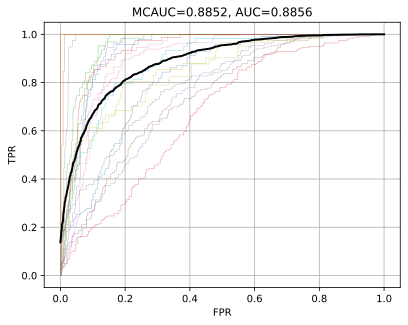

In [23]:
plot_roc(tagnames, train_classes, train_predscore)

Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

Now apply the LR classifiers to the test set to predict the score for each tag.

In [24]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


We have the scores, now lets look at the predicted tags.

In [96]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        # tags.append(" ".join(tmp))
        tags.append(tmp)
    return tags

We need to convert the score into a binary class label using a threshold (usually 0).

In [ ]:
# convert score into binary class 0 or 1.  
test_predclass = test_predscore>0

# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

Here is an example of the predicted labels and the label scores.

bizarre cheerful creepy rhythmic speedy tense


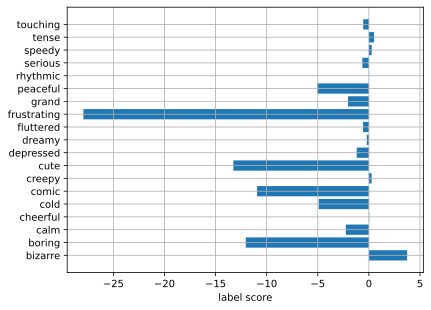

In [27]:
ii = 0
# view tags and audio
print(test_predtags[ii])
showAudio(test_info[ii])

# view the scores
plt.barh(tagnames, test_predscore[ii]);
plt.xlabel('label score')
plt.grid(True)

Now write the tag scores for the test set for submission to Kaggle. We need to upload the tag scores so that Kaggle can generate the ROC curves and calculate AUC.

In [42]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [29]:
write_csv_kaggle_tags("music_bow_baseline.csv", tagnames, test_predscore)

## YOUR CODE and DOCUMENTATION HERE

## Data Analysis

In [11]:
import seaborn as sns
import librosa

### The distribution of each tags in training dataset

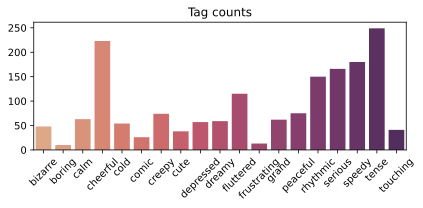

In [31]:
plt.figure(figsize=(6,3))
sns.barplot(x=tagnames, y=tagnames_counts, palette='flare')
plt.title('Tag counts')
plt.xticks(rotation=45)
plt.tight_layout()

### Analysis based on the visualization
+ Accoring to the plot, the distribution of each tags in training dataset is not uniform. Thus, need to balance the sample by weighting.

### Load the music in the waveform by librosa
+ Using the [librosa](https://librosa.org/) (An audio processing and analysis library) load each music for subsequent other feature extraction

In [13]:
train_info[0]

{'id': 'ndvf012m',
 'tags': ['tense', 'speedy', 'rhythmic'],
 'top_tag': 'tense',
 'fname': 'ndvf012m'}

In [12]:
def get_waveform_audio(music_data):
    wav_audio_list = []
    sample_rate_list = []
    for info in music_data:
        filename = 'musicmp3/' + info['fname'] + '.mp3'
        y, sr = librosa.load(filename, sr=16000)
        wav_audio_list.append(y)
        sample_rate_list.append(sr)
    return wav_audio_list, sample_rate_list

In [13]:
train_wav, train_sr = get_waveform_audio(train_info)
test_wav, test_sr = get_waveform_audio(test_info)

### The mean of each duration of tag's music

In [ ]:
def get_duration(wav_data, sr_data):
    duration_list = []
    for i in range(len(wav_data)):
        duration = librosa.get_duration(y=wav_data[i], sr=sr_data[i])
        duration_list.append(duration)
    return duration_list

In [ ]:
train_duration = get_duration(train_wav, train_sr)
test_duration = get_duration(test_wav, test_sr)

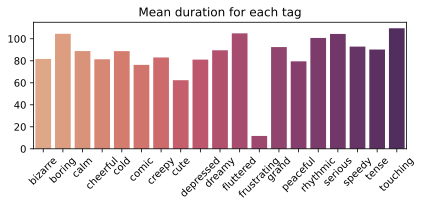

In [ ]:
# get the duration for each tags
mean_tag_duration = []
for i, tag in enumerate(tagnames):
    tag_duration = []
    for j in range(len(train_info)):
        if train_classes[j, i]:
            tag_duration.append(train_duration[j])
    mean_tag_duration.append(mean(tag_duration))

plt.figure(figsize=(6,3))
sns.barplot(x=tagnames, y=mean_tag_duration, palette='flare')
plt.title('Mean duration for each tag')
plt.xticks(rotation=45)
plt.tight_layout()

### Analysis based on the visualization
+ According to the mean duration of each tag's music, it has different value in different music labls, which can also be a feature for classification.

## Other Feature Extraction Methods
Try some other feature, not only the Spectral features, but Rhythm features:
+ Spectral features:
  + The Chromagram from a waveform or power spectrogram, which is a representative of a chroma vector which captures the harmonic order of an audio signal .
  + The Root Mean Square Energy. The RMSE is simply the square root of the mean squared amplitude over a time window. Compute RMS value for each frame, either from the audio samples y or from a spectrogram S.
+ Rhythm features:
  + The Tempo is the estimated beat per minute of the audio signal.
  + The Tempogram is a feature matrix which indicates the prevalence of certain tempi at each moment in time. Librosa has a built-in function to extract this information. Compute a local autocorrelation of the onset strength envelope.


In [ ]:
def get_mfcc(wav_data, sr_data):
    mfcc_list = []
    for i in range(len(wav_data)):
        mfcc = librosa.feature.mfcc(y=wav_data[i], sr=sr_data[i])
        mfcc_list.append(mfcc)
    return mfcc_list

In [ ]:
train_mfcc_from_wav = get_mfcc(train_wav, train_sr)
test_mfcc_from_wav = get_mfcc(test_wav, test_sr)

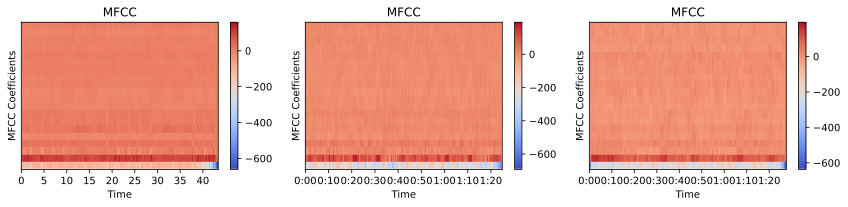

In [ ]:
# visualize the mfcc in three songs
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    librosa.display.specshow(train_mfcc_from_wav[i], x_axis='time')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
def get_chroma_stft(wav_data, sr_data):
    chroma_stft_list = []
    for i in range(len(wav_data)):
        chroma_stft = librosa.feature.chroma_stft(y=wav_data[i], sr=sr_data[i])
        chroma_stft_list.append(chroma_stft)
    return chroma_stft_list

In [ ]:
train_chroma_stft = get_chroma_stft(train_wav, train_sr)
test_chroma_stft = get_chroma_stft(test_wav, test_sr)

C:\Users\huancwang2\AppData\Roaming\Python\Python39\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


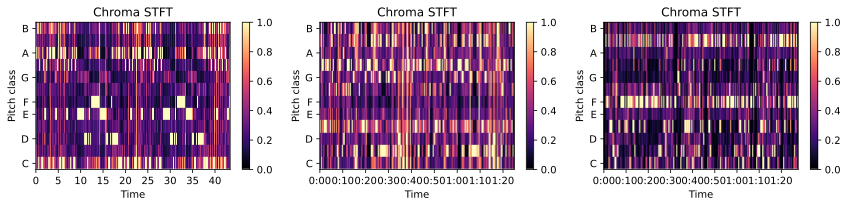

In [ ]:
# visualize the chroma_stft in three songs
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title('Chroma STFT')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    librosa.display.specshow(train_chroma_stft[i], x_axis='time', y_axis='chroma')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
def get_rms(wav_data):
    rms_list = []
    for i in range(len(wav_data)):
        rms = librosa.feature.rms(y=wav_data[i])
        rms_list.append(rms)
    return rms_list

In [ ]:
train_rms = get_rms(train_wav)
test_rms = get_rms(test_wav)

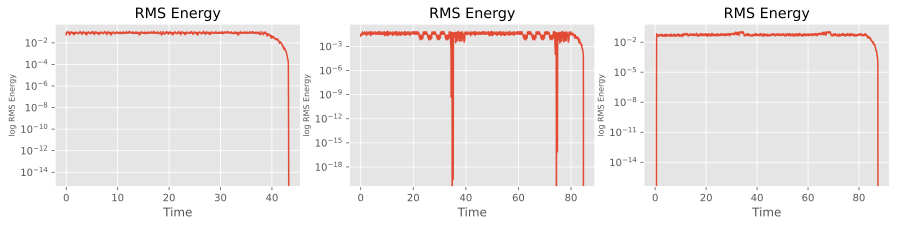

In [ ]:
# visualize the rms
plt.figure(figsize=(15,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.style.use('ggplot')
    plt.title('RMS Energy')
    plt.xlabel('Time')
    plt.ylabel('log RMS Energy', fontdict={'fontsize': 8})
    times = librosa.times_like(train_rms[i])
    plt.semilogy(times, train_rms[i][0], label='RMS Energy')
plt.show()

In [ ]:
def get_tempo(wav_data, sr_data):
    tempo_list = []
    for i in range(len(wav_data)):
        onset_env = librosa.onset.onset_strength(y=wav_data[i], sr=sr_data[i])
        tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr_data[i])
        tempo_list.append(tempo)
    return tempo_list

In [ ]:
train_tempo = get_tempo(train_wav, train_sr)
test_tempo = get_tempo(test_wav, test_sr)

In [ ]:
def get_tempogram(wav_data, sr_data):
    tempogram_list = []
    for i in range(len(wav_data)):
        tempogram = librosa.feature.tempogram(y=wav_data[i], sr=sr_data[i])
        tempogram_list.append(tempogram)
    return tempogram_list

In [ ]:
train_tempogram = get_tempogram(train_wav, train_sr)
test_tempogram = get_tempogram(test_wav, test_sr)

C:\Users\huancwang2\AppData\Local\Temp\ipykernel_13412\4121591089.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


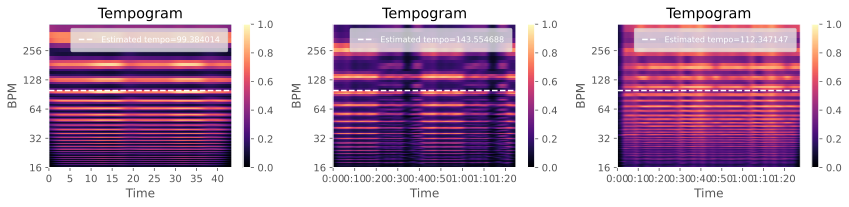

In [ ]:
# visualize the tempogram

plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.title('Tempogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    librosa.display.specshow(train_tempogram[i], x_axis='time', y_axis='tempo', cmap='magma')
    plt.axhline(train_tempo[ii], color='w', linestyle='--', alpha=1,
                label='Estimated tempo={:f}'.format(train_tempo[i][0]))
    plt.colorbar()
    plt.legend(loc='upper right', prop={'size': 8}, labelcolor='white',borderpad=1)
plt.tight_layout()
plt.show()

In [25]:
def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [15]:
save_pickle(train_mfcc_from_wav, 'train_mfcc_from_wav.pkl')
save_pickle(test_mfcc_from_wav, 'test_mfcc_from_wav.pkl')
save_pickle(train_chroma_stft, 'train_chroma_stft.pkl')
save_pickle(test_chroma_stft, 'test_chroma_stft.pkl')
save_pickle(train_rms, 'train_rms.pkl')
save_pickle(test_rms, 'test_rms.pkl')
save_pickle(train_tempo, 'train_tempo.pkl')
save_pickle(test_tempo, 'test_tempo.pkl')
save_pickle(train_tempogram, 'train_tempogram.pkl')
save_pickle(test_tempogram, 'test_tempogram.pkl')
save_pickle(train_wav, 'train_wav.pkl')
save_pickle(test_wav, 'test_wav.pkl')
save_pickle(train_sr, 'train_sr.pkl')
save_pickle(test_sr, 'test_sr.pkl')

## Using the Baseline features by bag-of-bow from dmfcc to set a better classification model 
+ Linear SVM
+ poly kernel SVM
+ rbf kernel SVM
+ adaboost
+ random forest

### Split the training dataset into training and validation dataset, and the ratio is 0.8:0.2

In [ ]:
train_data, valid_data, train_label, valid_label = model_selection.train_test_split(train_Xtf, train_classes, test_size=0.2, random_state=42)

In [ ]:
def diff_models(train_X, train_Y, name):
    tagmodels = {}
    print('Training %s model for each tag (multilabel)' % name)
    for i,t in enumerate(tagnames):
        myY = train_Y[:,i].ravel()
        if name=='linear SVM':
            model = model_selection.GridSearchCV(svm.SVC(kernel='linear', class_weight='balanced'), param_grid={'C':logspace(-4,4,5)}, cv=5)
        elif name=='poly':
            model = model_selection.GridSearchCV(svm.SVC(kernel='poly', class_weight='balanced'), param_grid={'C':logspace(-4,4,5), 'degree':[2,3,4]}, cv=5)
        elif name=='rbf':
            model = model_selection.GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid={'C':logspace(-4,4,5), 'gamma':logspace(-4,4,5)}, cv=5)
        elif name=='adaboost':
            model = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators':[10,50,100,200],'learning_rate':logspace(-4,4,5)}, cv=5)
        elif name=='random forest':
            model = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators':[10,50,100,200],'max_depth':[2,3,4]}, cv=5)
        model.fit(train_X, myY)
        tagmodels[t] = model
    return tagmodels

In [ ]:
model_list = ['linear SVM', 'poly', 'rbf', 'adaboost', 'random forest']
model_dict = {}
for model in model_list:
    tagmodels = diff_models(train_data, train_label, model)
    
    valid_predscore = zeros(shape=(len(valid_data.toarray()), len(tagnames)))

    for i,t in enumerate(tagnames):
        if model!='adaboost' and model!='random forest':
            tmp = tagmodels[t].decision_function(valid_data)
        else:
            tmp = tagmodels[t].predict_proba(valid_data)[:, 1]
        valid_predscore[:,i] = tmp
    model_dict[model] = valid_predscore


Training linear SVM model for each tag (multilabel)
Training poly model for each tag (multilabel)
Training rbf model for each tag (multilabel)
Training adaboost model for each tag (multilabel)
Training random forest model for each tag (multilabel)


linear SVM model performance in valid set


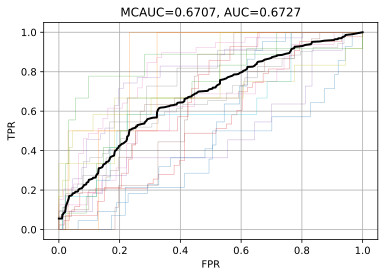

In [ ]:
print('linear SVM model performance in valid set')
plot_roc(tagnames, valid_label, model_dict['linear SVM'])

Poly kernel SVM model performance in valid set


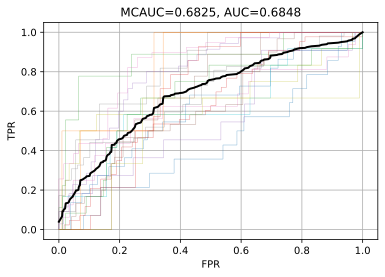

In [ ]:
print('Poly kernel SVM model performance in valid set')
plot_roc(tagnames, valid_label, model_dict['poly'])

rbf kernel SVM model performance in valid set


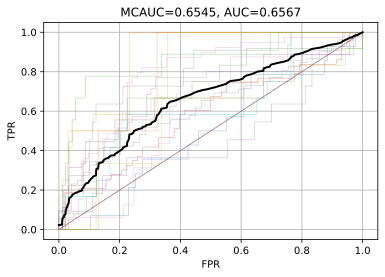

In [ ]:
print('rbf kernel SVM model performance in valid set')
plot_roc(tagnames, valid_label, model_dict['rbf'])

Adaboost model performance in valid set


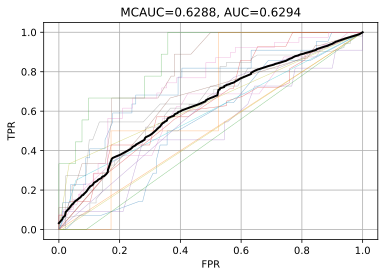

In [ ]:
print('Adaboost model performance in valid set')
plot_roc(tagnames, valid_label, model_dict['adaboost'])

Random Forest model performance in valid set


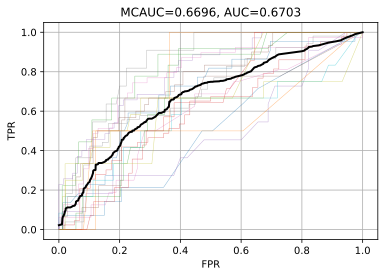

In [ ]:
print('Random Forest model performance in valid set')
plot_roc(tagnames, valid_label, model_dict['random forest'])

### According to the ROC plot, the Random Forest and poly kernel SVM model perform better.
+ Then, we will find best number of bow (number of cluster in Kmeans)
+ We will aslo find the best number of component (number of component in PCA)

In [ ]:
def cal_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    return auc

In [ ]:
# Number of cluster

def find_best_k(all_data, train_data, train_Y, valid_data, valid_Y):
    bset_auc = 0
    num_cluster = [100, 200, 500, 1000]
    for num in num_cluster:
        km = cluster.KMeans(n_clusters=num, random_state=4487)
        km.fit(all_data[0::100])  # subsample by 10 to make it faster
        km.cluster_centers_
        train_bow = bow_transform(km, train_data)
        valid_bow = bow_transform(km, valid_data)
        # convert to TF
        tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
        train_Xtf = tf_trans.fit_transform(train_bow)
        valid_Xtf = tf_trans.transform(valid_bow)
        tagmodels = {}
        for i,t in enumerate(tagnames):
            myY = train_Y[:,i].ravel()
            rr_cv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators':[10,50,100,200],'max_depth':[2,3,4,5]}, cv=5)
            rr_cv.fit(train_Xtf, myY)
            tagmodels[t] = rr_cv

        valid_predscore = zeros(shape=(len(valid_data), len(tagnames)))
        for i,t in enumerate(tagnames):

            tmp = tagmodels[t].predict_proba(valid_Xtf)[:, 1]
            valid_predscore[:,i] = tmp
        auc = cal_roc(tagnames, valid_Y, valid_predscore)
        if auc > bset_auc:
            bset_auc = auc
            best_num = num
    print('best number of cluster is {}, with auc {}'.format(best_num, bset_auc))

In [ ]:
train_data, valid_data, train_label, valid_label = model_selection.train_test_split(train_dmfccs, train_classes, test_size=0.2, random_state=42)

In [ ]:
find_best_k(all_dmfccs, train_data, train_label, valid_data, valid_label)

best number of cluster is 100, with auc 0.6688550162092066


### According to the result, we can get the best number of bow is 500.

In [ ]:
# Number of component in PCA

def find_best_com(all_data, train_data, train_Y, valid_data, valid_Y):
    bset_auc = 0
    num_cluster = 500
    number_com = [20, 50, 80, 100, 200]
    auc_list = []
    km = cluster.KMeans(n_clusters=num_cluster, random_state=4487)
    km.fit(all_data[0::100])  # subsample by 10 to make it faster
    km.cluster_centers_
    train_bow = bow_transform(km, train_data)
    valid_bow = bow_transform(km, valid_data)
    # convert to TF
    tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
    train_Xtf = tf_trans.fit_transform(train_bow)
    valid_Xtf = tf_trans.transform(valid_bow)
    for num in number_com:
        pca = decomposition.PCA(n_components=num)
        train_Xtf_PCA = pca.fit_transform(train_Xtf.toarray())
        valid_Xtf_PCA = pca.transform(valid_Xtf.toarray())
        tagmodels = {}
        for i,t in enumerate(tagnames):
            myY = train_Y[:,i].ravel()
            rr_cv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators':[10,50,100,200],'max_depth':[2,3,4,5]}, cv=5)
            rr_cv.fit(train_Xtf_PCA, myY)
            tagmodels[t] = rr_cv

        valid_predscore = zeros(shape=(len(valid_data), len(tagnames)))
        for i,t in enumerate(tagnames):

            tmp = tagmodels[t].predict_proba(valid_Xtf_PCA)[:, 1]
            valid_predscore[:,i] = tmp
        auc = cal_roc(tagnames, valid_Y, valid_predscore)
        auc_list.append(auc)
        if auc > bset_auc:
            bset_auc = auc
            best_num = num
            best_tagmodels = tagmodels
    plt.plot(number_com, auc_list)
    plt.xlabel('number of components')
    plt.ylabel('AUC')
    print('best number of cluster is {}, with auc {}'.format(best_num, bset_auc))
    return best_tagmodels

best number of cluster is 20, with auc 0.6792451255623689


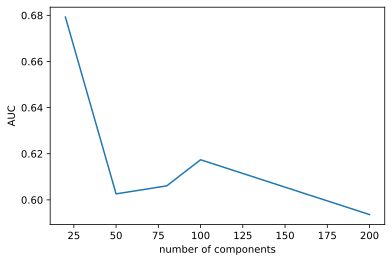

In [ ]:
best_tagmodels = find_best_com(all_dmfccs, train_data, train_label, valid_data, valid_label)

### According to the result, we can get the best number of component is 50 using PCA.

In [ ]:
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
train_bow = bow_transform(km, train_data)
valid_bow = bow_transform(km, valid_data)
test_bow =  bow_transform(km, test_dmfccs)
pca = decomposition.PCA(n_components=20)
train_bow_PCA = pca.fit_transform(train_bow)
valid_bow_PCA = pca.transform(valid_bow)
test_bow_PCA = pca.transform(test_bow)


In [ ]:
tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_label[:,i].ravel()
    rr_cv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators':[10,50,100,200],'max_depth':[2,3,4,5]}, cv=5)
    rr_cv.fit(train_bow_PCA, myY)
    tagmodels[t] = rr_cv

valid_predscore = zeros(shape=(len(valid_data), len(tagnames)))
for i,t in enumerate(tagnames):

    tmp = tagmodels[t].predict_proba(valid_bow_PCA)[:, 1]
    valid_predscore[:,i] = tmp

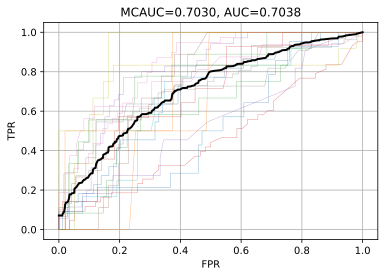

In [ ]:
plot_roc(tagnames, valid_label, valid_predscore)

### According to the result, we can find the perfomance of the model is better than above models after tuning the number of bows and number of components.

In [ ]:
tagmodels
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))
for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].predict_proba(test_bow_PCA)[:, 1]
    test_predscore[:,i] = tmp

write_csv_kaggle_tags("music_bow_rr.csv", tagnames, test_predscore)

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


## First, try these feature without time series

In [11]:
train_wav = load_pickle('train_wav.pkl')
test_wav = load_pickle('test_wav.pkl')
train_sr = load_pickle('train_sr.pkl')
test_sr = load_pickle('test_sr.pkl')
train_chroma_stft = load_pickle('train_chroma_stft.pkl')
test_chroma_stft = load_pickle('test_chroma_stft.pkl')
train_mfcc_from_wav = load_pickle('train_mfcc_from_wav.pkl')
test_mfcc_from_wav = load_pickle('test_mfcc_from_wav.pkl')
train_rms = load_pickle('train_rms.pkl')
test_rms = load_pickle('test_rms.pkl')
train_tempo = load_pickle('train_tempo.pkl')
test_tempo = load_pickle('test_tempo.pkl')
train_tempogram = load_pickle('train_tempogram.pkl')
test_tempogram = load_pickle('test_tempogram.pkl')

In [ ]:
X_train = []

for i in range(len(train_wav)):
    tmp = []
    feature = mean(train_rms[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(train_mfcc_from_wav[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(train_chroma_stft[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(train_tempogram[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    X_train.append(tmp)

X_test = []

for i in range(len(test_wav)):
    tmp = []
    feature = mean(test_rms[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(test_mfcc_from_wav[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(test_chroma_stft[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    feature = mean(test_tempogram[i], axis=1)
    for i in range(len(feature)):
        tmp.append(feature[i])
    X_test.append(tmp)


In [ ]:
X_train = array(X_train)
X_test = array(X_test)
train_data, valid_data, train_label, valid_label = model_selection.train_test_split(X_train, train_classes, test_size=0.2, random_state=4487)

In [ ]:
std_process = preprocessing.StandardScaler()
train_data = std_process.fit_transform(train_data)
valid_data = std_process.transform(valid_data)

tagmodels = {}
for i,t in enumerate(tagnames):
    train_myY = train_classes[:,i].ravel()

    rr_cv = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators':[10,50,100,200],'max_depth':[2,3,4,5]}, cv=5)
    rr_cv.fit(train_data, train_myY)
    tagmodels[t] = rr_cv

valid_predscore = zeros(shape=(len(valid_data), len(tagnames)))
best_auc = 0
for i,t in enumerate(tagnames):
    tmp = tagmodels[t].predict_proba(valid_data)[:, 1]
    valid_predscore[:,i] = tmp


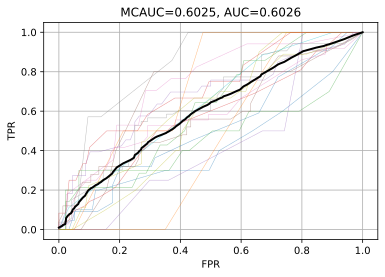

In [ ]:
plot_roc(tagnames, valid_label, valid_predscore)

### According to the result, We can find that only add the number of features rather than ignore the temporal information, the performance of the model is not good.

In [ ]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))
for i,t in enumerate(tagnames):
    
        tmp = tagmodels[t].predict_proba(X_test)[:, 1]
        test_predscore[:,i] = tmp

write_csv_kaggle_tags("agg_feature_lgbm.csv", tagnames, test_predscore)

### All of them are the features with time seires dependency. 
### Thus, I try some other more advanced features and models to keep position information (tempo dependency).

## Try some new features and models out of the lecture:
## The Audio Spectrogram Transformer based on the Wav2Vec:
Using end to end to complete all step including:
+ Feature extraction from music audio
+ Multi-label classification for each music audio.

In [12]:

import datasets

from transformers import AutoFeatureExtractor,Wav2Vec2ForSequenceClassification


Split the training dataset into training and validation dataset, and the ratio is 0.9:0.1

In [13]:
train_X, val_X, train_Y, val_Y = model_selection.train_test_split(train_wav, train_classes, test_size=0.1, random_state=4487)

In [14]:
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/wav2vec2-base-960h')

train_dataset= datasets.Dataset.from_dict({'audio':train_X, 'label':train_Y})
val_dataset= datasets.Dataset.from_dict({'audio':val_X, 'label':val_Y})
test_dataset = datasets.Dataset.from_dict({'audio':test_wav})

In [17]:
def wav_embedding(examples):
    return feature_extractor(examples["audio"], sampling_rate=16000, truncation=True, padding="max_length", max_length=160000, return_tensors="pt")

In [18]:
train_dataset = train_dataset.map(wav_embedding, remove_columns=["audio"])
val_dataset = val_dataset.map(wav_embedding, remove_columns=["audio"])
test_dataset = test_dataset.map(wav_embedding, remove_columns=["audio"])

  0%|          | 0/450 [00:00<?, ?ex/s]

  0%|          | 0/51 [00:00<?, ?ex/s]

  0%|          | 0/168 [00:00<?, ?ex/s]

In [22]:
X_train = [train_dataset[i]['input_values'] for i in range(len(train_dataset))]
Y_train = [train_dataset[i]['label'] for i in range(len(train_dataset))]
X_val = [val_dataset[i]['input_values'] for i in range(len(val_dataset))]
Y_val = [val_dataset[i]['label'] for i in range(len(val_dataset))]
X_test = [test_dataset[i]['input_values'] for i in range(len(test_dataset))]

In [26]:
save_pickle(X_train, 'X_train.pkl')
save_pickle(Y_train, 'Y_train.pkl')
save_pickle(X_val, 'X_val.pkl')
save_pickle(Y_val, 'Y_val.pkl')
save_pickle(X_test, 'X_test.pkl')


In [14]:
X_train = load_pickle('X_train.pkl')
Y_train = load_pickle('Y_train.pkl')
X_val = load_pickle('X_val.pkl')
Y_val = load_pickle('Y_val.pkl')
X_test = load_pickle('X_test.pkl')


In [48]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten
import keras_tuner as kt

In [15]:
timesteps = 128
input_dim = 1250


In [17]:
X_train = array([array(X_train[i]).reshape(timesteps, input_dim) for i in range(len(X_train))])
X_val = array([array(X_val[i]).reshape(timesteps, input_dim) for i in range(len(X_val))])
X_test = array([array(X_test[i]).reshape(timesteps, input_dim) for i in range(len(X_test))])
Y_train = array([array(Y_train[i]) for i in range(len(Y_train))])
Y_val = array([array(Y_val[i]) for i in range(len(Y_val))])

### To deal with the temporal data, we can use the Bi-LSTM to extract the temporal information.
Here are some reasons:
1. Bi-directional processing: Bi-LSTMs process input data in both forward and backward directions, allowing them to capture information from past and future time steps. This helps them to better model complex temporal relationships in the data.

2. Long Short-Term Memory (LSTM) cells: LSTMs are a type of recurrent neural network (RNN) that are designed to address the problem of vanishing gradients that can occur in traditional RNNs. LSTMs use memory cells to store information over long periods of time, which makes them well-suited for tasks that require modeling temporal dependencies.

3. Non-linear transformations: Bi-LSTMs use non-linear activation functions, such as sigmoid and hyperbolic tangent, to transform input data into a more expressive feature space. This allows them to capture complex patterns in the input data that may be missed by simpler models.

4. Flexibility: Bi-LSTMs can be used in a variety of contexts, including sequence classification, sequence labeling, and sequence-to-sequence mapping. They can also be combined with other types of neural networks, such as convolutional neural networks (CNNs), to further improve performance.

In [49]:
def build_model(hp):
    model = Sequential()
    
    # Add LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True), input_shape=(timesteps, input_dim)))
    
    # Add Conv1D layer
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=256, step=32), kernel_size=hp.Int('kernel_size', min_value=3, max_value=15, step=2), activation='relu'))
    
    # Add MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=8, step=2)))
    
    # Add Flatten layer
    model.add(Flatten())
    
    # Add Dense layers
    model.add(Dense(units=hp.Int('dense_units_1', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=19, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), metrics=[tf.keras.metrics.AUC(curve='ROC')])
    
    return model


### Run serval trails to do the hyperparameter tuning and model structure building.

In [52]:
# Define the hyperparameter search space
tuner = kt.Hyperband(build_model,kt.Objective('val_auc', direction='max'), max_epochs=10, factor=3, directory='my_dir', project_name='my_project')

# Define the callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), callbacks=[early_stop])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

# Build the model with the best hyperparameters and train on the full training dataset
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val))

# Evaluate the model on the test dataset
val_loss, val_auc = model.evaluate(X_val, Y_val)

# Make predictions on the test dataset
predictions = model.predict(X_test)

Trial 30 Complete [00h 03m 12s]
val_auc: 0.7734394073486328

Best val_auc So Far: 0.8359509706497192
Total elapsed time: 00h 36m 22s
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001CA1C7B03A0>
Epoch 1/50
15/15 [==============================] - 10s 507ms/step - loss: 0.5137 - auc_1: 0.6436 - val_loss: 0.3801 - val_auc_1: 0.7624
Epoch 2/50
15/15 [==============================] - 6s 405ms/step - loss: 0.4204 - auc_1: 0.7401 - val_loss: 0.3636 - val_auc_1: 0.8006
Epoch 3/50
15/15 [==============================] - 4s 291ms/step - loss: 0.3793 - auc_1: 0.8023 - val_loss: 0.3522 - val_auc_1: 0.8276
Epoch 4/50
15/15 [==============================] - 4s 287ms/step - loss: 0.3431 - auc_1: 0.8468 - val_loss: 0.3521 - val_auc_1: 0.8215
Epoch 5/50
15/15 [==============================] - 4s 287ms/step - loss: 0.2998 - auc_1: 0.8880 - val_loss: 0.3635 - val_auc_1: 0.8183
Epoch 6/50
15/15 [==========

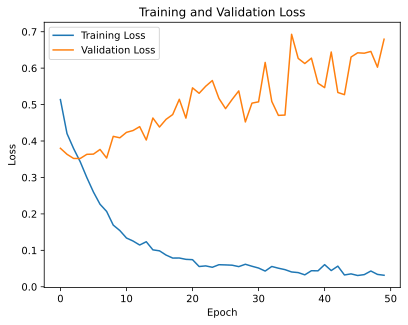

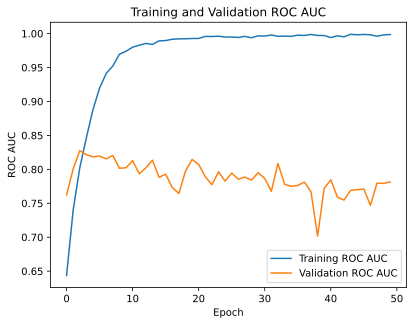

In [59]:
import matplotlib.pyplot as plt

# Train the model

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the ROC AUC score over epochs
plt.plot(history.history['auc_1'], label='Training ROC AUC')
plt.plot(history.history['val_auc_1'], label='Validation ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()


### According to the result, The loss get larger and ROC_AUC get smaller when training several epochs.
There are some reasons:
1. The model might be overfitting the training data, which means it is too complex and has learned to fit the noise in the training data instead of the underlying patterns.
2. If the dataset is imbalanced, meaning some classes have more samples than others, the model might be biased towards the majority classes and struggle to classify the minority classes. 
3. The learning rate might be too high, causing the model to overshoot the optimal weights and getting stuck in a suboptimal solution. 

Thus, I try to do some improvement

In [98]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer
# to_categorical

In [112]:
import pandas as pd

train_df = pd.DataFrame(data=Y_train, columns=tagnames)

### Balanced the dataset by the binary number in each label.

In [115]:
def calculating_class_weights(y_true):
    positive_weights = {}
    negative_weights = {}
    for c in tagnames:
        positive_weights[c] = train_df.shape[0]/(2*count_nonzero(train_df[c]==1))
        negative_weights[c] = train_df.shape[0]/(2*count_nonzero(train_df[c]==0))
    print(positive_weights)
    print(negative_weights)
    return positive_weights, negative_weights

In [116]:
positive_weights, negative_weights = calculating_class_weights(class2tags(Y_train, tagnames))

{'bizarre': 5.0, 'boring': 25.0, 'calm': 4.090909090909091, 'cheerful': 1.125, 'cold': 4.245283018867925, 'comic': 9.0, 'creepy': 3.4615384615384617, 'cute': 6.428571428571429, 'depressed': 4.411764705882353, 'dreamy': 4.090909090909091, 'fluttered': 2.102803738317757, 'frustrating': 17.307692307692307, 'grand': 4.017857142857143, 'peaceful': 3.3582089552238807, 'rhythmic': 1.6791044776119404, 'serious': 1.4610389610389611, 'speedy': 1.3719512195121952, 'tense': 1.0273972602739727, 'touching': 6.25}
{'bizarre': 0.5555555555555556, 'boring': 0.5102040816326531, 'calm': 0.569620253164557, 'cheerful': 0.9, 'cold': 0.5667506297229219, 'comic': 0.5294117647058824, 'creepy': 0.5844155844155844, 'cute': 0.5421686746987951, 'depressed': 0.5639097744360902, 'dreamy': 0.569620253164557, 'fluttered': 0.6559766763848397, 'frustrating': 0.5148741418764302, 'grand': 0.5710659898477157, 'peaceful': 0.587467362924282, 'rhythmic': 0.7120253164556962, 'serious': 0.7601351351351351, 'speedy': 0.786713286

In [134]:

def loss_fn(y_true,y_pred):
    loss = 0
    for i in range(len(tagnames)):
        try:
            loss -= (positive_weights[tagnames[i]]*y_true[i]*tf.keras.backend.log(y_pred[i]) + negative_weights[tagnames[i]]*(1-y_true[i])*tf.keras.backend.log(1-y_pred[i]))
        except:
            print(i)
    return loss

### Rerun the model to get the better result.

In [160]:

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(19, activation='softmax'))


# Compile the model
opt = tf.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])

# Set up early stopping and history callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = tf.keras.callbacks.History()

# Train the model
history = model.fit(X_train,Y_train, epochs=15, verbose = 1, batch_size=32,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stop, history])



Epoch 1/15
15/15 [==============================] - 7s 158ms/step - loss: 0.6585 - accuracy: 0.0400 - auc_18: 0.5846 - val_loss: 0.6149 - val_accuracy: 0.0784 - val_auc_18: 0.6040
Epoch 2/15
15/15 [==============================] - 1s 84ms/step - loss: 0.5899 - accuracy: 0.0556 - auc_18: 0.6058 - val_loss: 0.5301 - val_accuracy: 0.1373 - val_auc_18: 0.6501
Epoch 3/15
15/15 [==============================] - 1s 85ms/step - loss: 0.5212 - accuracy: 0.3111 - auc_18: 0.6207 - val_loss: 0.4678 - val_accuracy: 0.4314 - val_auc_18: 0.6601
Epoch 4/15
15/15 [==============================] - 1s 82ms/step - loss: 0.4795 - accuracy: 0.4133 - auc_18: 0.6393 - val_loss: 0.4352 - val_accuracy: 0.4510 - val_auc_18: 0.6768
Epoch 5/15
15/15 [==============================] - 1s 84ms/step - loss: 0.4566 - accuracy: 0.4156 - auc_18: 0.6544 - val_loss: 0.4167 - val_accuracy: 0.4510 - val_auc_18: 0.6903
Epoch 6/15
15/15 [==============================] - 1s 84ms/step - loss: 0.4410 - accuracy: 0.3711 - auc

In [162]:
tup = model.evaluate(X_val, Y_val)

y_pred = model.predict(expand_dims(X_test, axis=-1))

6/6 [==============================] - 1s 37ms/step


In [172]:
write_csv_kaggle_tags('submission.csv', tagnames, y_pred)

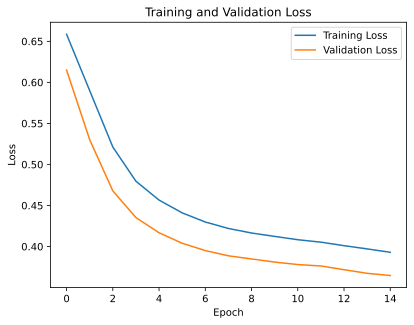

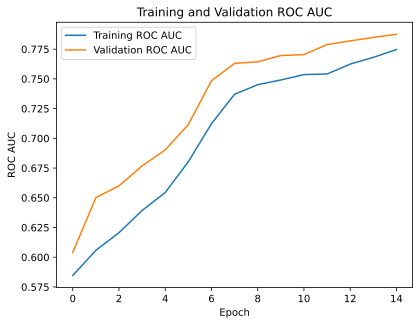

In [161]:
import matplotlib.pyplot as plt

# Train the model

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the ROC AUC score over epochs
plt.plot(history.history['auc_18'], label='Training ROC AUC')
plt.plot(history.history['val_auc_18'], label='Validation ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()


### According to the result:
The model is not overfitting the training data, and the ROC_AUC is getting better on the validation dataset.

## Conclusion
In Conclusion, There are some methods to improve the multi-label music tags classification:
1. For bag-of-audio words, we tuning the number of bows and number of components using PCA to get the better result.
2. For the ML model in lecture, the Random Forest and rbf kernel SVM model perform better just using the bow data rather than the TF-IDF data.
3. For other feature extraction, since the audio has the temporal information, just expand the dim of features is not useful without time-seires.
  First: Try multiple features: includeing:
   + Spectral features:
     + The Chromagram from a waveform or power spectrogram, which is a representative of a chroma vector which captures the harmonic order of an audio signal .
     + The Root Mean Square Energy. The RMSE is simply the square root of the mean squared amplitude over a time window. Compute RMS value for each frame, either from the audio samples y or from a spectrogram S.
   + Rythm features:
     + The Tempo is the estimated beat per minute of the audio signal.
     + The Tempogram is a feature matrix which indicates the prevalence of certain tempi at each moment in time. Librosa has a built-in function to extract this information. Compute a local autocorrelation of the onset strength envelope.
  Second: Using the Wav2vec to extract the features from audio, and then use the Bi-LSTM to extract the temporal information.
4. For the model, we can use the Bi-LSTM to extract the temporal information. also need focus on problem of the overfittng and the imbalanced dataset.


## Acknowledgement
Some of the code is from the following sources:
+ [librosa](https://librosa.org/)
+ [Wav2Vec](https://huggingface.co/docs/transformers/model_doc/wav2vec2)
+ [Bi-LSTM](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)